In [2]:
import pandas as pd

df = pd.read_csv('StudentsPerformance.csv')

for cname, series in df.iloc[:,:-3].items():
    print(cname, series.unique())


gender ['female' 'male']
race/ethnicity ['group B' 'group C' 'group A' 'group D' 'group E']
parental level of education ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
lunch ['standard' 'free/reduced']
test preparation course ['none' 'completed']


In [3]:
#coding the variables

df['group B'] = (df['race/ethnicity'] == 'group B').astype(int)
df['group C'] = (df['race/ethnicity'] == 'group C').astype(int)
df['group D'] = (df['race/ethnicity'] == 'group D').astype(int)
df['group E'] = (df['race/ethnicity'] == 'group E').astype(int)

levels_of_education = {
    'some high school': 1, 
    'high school': 2,
    'some college': 3,
    "associate's degree": 4,
    "bachelor's degree": 5,
    "master's degree": 6,
}
df['parental_level_coded']=df['parental level of education'].map(levels_of_education)

genders = {
    'female': 0,
    'male': 1
}
df['gender_binary'] = df['gender'].map(genders)

lunches = {
    'standard': 1,
    'free/reduced': 0
}
df['lunch_binary'] = df['lunch'].map(lunches)

preparations = {
    'completed': 1,
    'none': 0
}
df['preparation_binary'] = df['test preparation course'].map(preparations)

dataset = df[['group B', 'group C', 'group D', 'group E', 'parental_level_coded', 'gender_binary', 'lunch_binary', 'preparation_binary']].copy()
dataset['avg_score'] = df[['math score', 'writing score', 'reading score']].mean(axis = 1)

print(dataset.head())

   group B  group C  group D  group E  parental_level_coded  gender_binary  \
0        1        0        0        0                     5              0   
1        0        1        0        0                     3              0   
2        1        0        0        0                     6              0   
3        0        0        0        0                     4              1   
4        0        1        0        0                     3              1   

   lunch_binary  preparation_binary  avg_score  
0             1                   0  72.666667  
1             1                   1  82.333333  
2             1                   0  92.666667  
3             0                   0  49.333333  
4             1                   0  76.333333  


<Axes: >

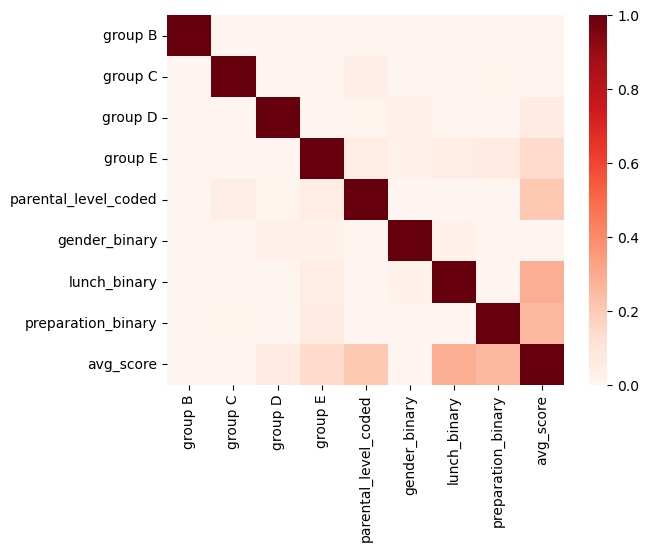

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
corrmat = dataset.corr()
sns.heatmap(corrmat, vmin = 0, cmap = 'Reds')

In [5]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

X = dataset.iloc[:,:-1]
Y = dataset.iloc[:,-1]
X = sm.add_constant(X)
test_y, train_y, test_x, train_x = train_test_split(Y, X, train_size = 0.2, random_state = 42)

model = sm.OLS(train_y, train_x)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              avg_score   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     32.34
Date:                Sat, 06 Dec 2025   Prob (F-statistic):           4.01e-44
Time:                        13:53:33   Log-Likelihood:                -3152.0
No. Observations:                 800   AIC:                             6322.
Df Residuals:                     791   BIC:                             6364.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   50.3514 

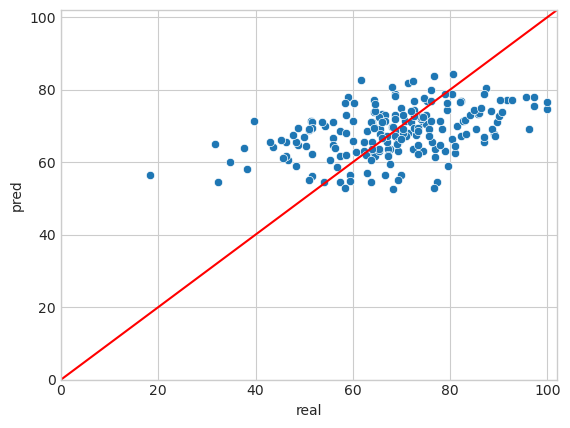

In [6]:
import numpy as np
pred_y = result.predict(test_x)

test_predictions = pd.DataFrame({
    'real': test_y,
    'pred': pred_y
})
y1, y2 = (Y.mean() - Y.std(), Y.mean() + Y.std())
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.xlim(0, 102)  
    plt.ylim(0, 102)  
    sns.scatterplot(data = test_predictions, x = 'real', y='pred')
    plt.plot([0, 102], [0, 102], c = 'r')


In [7]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def stat(real, pred):
    return (r2_score(real, pred), mean_squared_error(real, pred), mean_absolute_percentage_error(real, pred), mean_absolute_error(real, pred))
r2, MSE, MAPE, MAE = stat(test_y, pred_y)
print(f'r2 = {r2:.2f} \nMSE = {MSE:.2f} \nMAPE = {MAPE:.2%} \nMAE = {MAE:.2f}')


r2 = 0.19 
MSE = 155.71 
MAPE = 16.59% 
MAE = 9.88


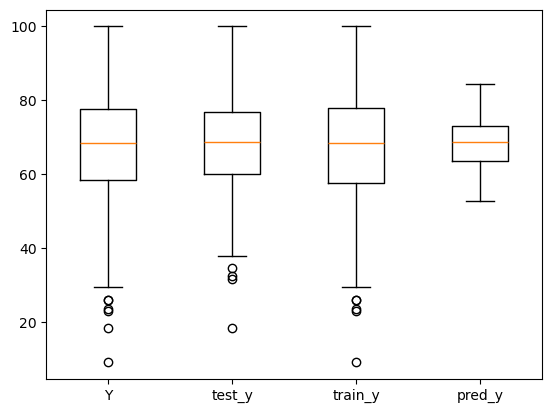

In [25]:
plt.boxplot([Y, test_y, train_y, pred_y], tick_labels = ['Y', 'test_y', 'train_y', 'pred_y']);

In [23]:
y1, y2 = (Y.mean() - Y.std(), Y.mean() + Y.std())
norm_stud = test_predictions[(test_predictions['real'] >= y1) & (test_predictions['real'] <= y2)]
notnorm_stud = test_predictions[(test_predictions['real'] < y1) | (test_predictions['real'] > y2)]
res1 = stat(norm_stud['real'], norm_stud['pred'])
res2 = stat(notnorm_stud['real'], notnorm_stud['pred'])

stats = pd.DataFrame({
    'Model': stat(test_y, pred_y),
    '+-std': res1,
    'out of std': res2
},
index = ['r2', 'MSE', 'MAPE', 'MAE']
)
print(stats.round(2))

       Model  +-std  out of std
r2      0.19  -0.49        0.34
MSE   155.71  73.29      348.05
MAPE    0.17   0.10        0.32
MAE     9.88   6.62       17.49


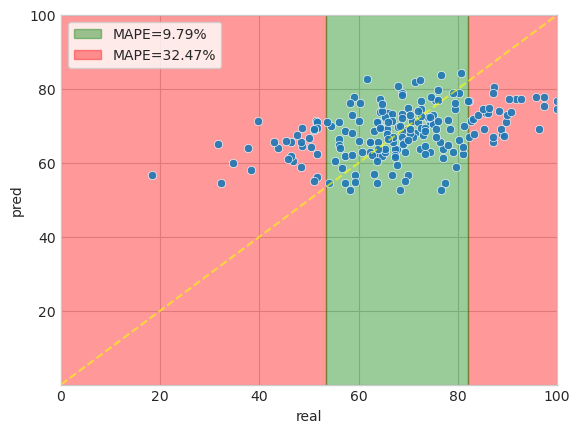

In [10]:
import matplotlib.patches as mpatches

with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.axvspan(0, y1, color = 'red', alpha = 0.4)
    plt.axvspan(y2, 100, color = 'red', alpha = 0.4)
    plt.axvspan(y1, y2, color = 'green', alpha = 0.4)
    plt.xlim(0, 100)  
    plt.ylim(0, 100)  
    plt.yticks(np.arange(20, 101, 20))
    sns.scatterplot(data = test_predictions, x = 'real', y='pred', alpha = 0.9)
    plt.plot([0, 100], [0, 100], c = 'yellow', alpha = 0.6, ls =  '--')
    red_patch = mpatches.Patch(color='red', alpha=0.4, label='MAPE=32.47%')
    green_patch = mpatches.Patch(color='green', alpha=0.4, label='MAPE=9.79%')
    plt.legend(handles=[green_patch, red_patch], loc='upper left', frameon=True)